# Solve elliptic PDE using Graph Neural Network



We want to solve the elliptic PDE problem
$$
\begin{cases}
    -\Delta u + u = 0 & \quad \text{in } G \\
    u(v) = g & \quad \forall v \in V_D \\
    \sum_{e \in E_v} \frac{\mathrm{d} u}{\mathrm{d} x^e}(v)=0
        & \quad \forall v \in V_N
    \end{cases}
$$
using our implementation of Graph Neural Network.
In particular, we set
$$
    g(x,y) = \begin{cases}
        2 & \quad \text{if } x \geq 0 \\
        1 & \quad \text{otherwise}
    \end{cases}
$$
and $V_D$ are the boundary vertices (the vertices which have only one outgoing edge).

Change working directory (remember to replace "path-to-your-directory" with your own directory)

In [ ]:
%cd /"path-to-your-directory"/GP-GNN

Import used source files


In [2]:
import numpy as np
import sys
import time
from tqdm import trange

from src.gnn.dataset import get_datasets, get_torch_graph
from src.gnn.buildModel import BuildModel
from src.graph.graph2D import Graph2D
from src.pde.ellipticPdeSolver2D import plot_solution_2d

Import neural network used and definition of fem problem

In [3]:
from examples.pde_with_gnn.pdeGNN import PdeGNN
from examples.pde_with_gnn.problem import Problem, get_node_features, get_edge_features
from examples.pde_with_gnn.main import compute_gnn_solution

Load plot function

In [4]:
from examples.discrete_laplacian.main import plot_testing

Force matplotlib to plot inline


In [5]:
%matplotlib inline

## Dataset

Create dataset

In [6]:
n_items = 500

for i in trange(n_items, ncols=100, file=sys.stdout):
    n = np.random.randint(25, 50)
    g = Graph2D.get_default_graph(n_vertexes=n)
    pde = Problem(g)
    pde.solve()
    in_feat = get_node_features(pde.mesh.get_vertexes().shape[0], g.get_boundary_mask())
    edge_feat = get_edge_features(pde.mesh.get_vertexes(), pde.mesh.get_full_edges())
    pde.save_object(f'examples/pde_with_gnn/dataset/pde_{i}', in_feat, edge_feat)

100%|█████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.67it/s]


## Build and train the network


Read dataset

In [7]:
batch_size = 4

train, val, test = get_datasets('examples/pde_with_gnn/dataset/pde', num_el=n_items, batch_size=batch_size,
                                division=[70, 20, 10])

Reading training data...
100%|███████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5552.55it/s]
Reading validation data...
100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6244.78it/s]
Reading testing data...
100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4572.35it/s]


Build model


In [8]:
model = BuildModel(PdeGNN(), train, val, "examples/pde_with_gnn/best_model")
model.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 5]                   --
|    └─Sequential: 2-1                   [-1, 5]                   --
|    |    └─Linear: 3-1                  [-1, 5]                   15
|    └─Sequential: 2-2                   [-1, 5]                   --
|    |    └─Linear: 3-2                  [-1, 5]                   20
├─ModuleList: 1                          []                        --
|    └─MessagePassingBlock: 2-3          [-1, 5]                   --
|    |    └─Sequential: 3-3              [-1, 5]                   215
|    |    └─SumAggregation: 3-4          [-1, 5]                   --
|    |    └─Sequential: 3-5              [-1, 5]                   325
|    └─MessagePassingBlock: 2-4          [-1, 5]                   --
|    |    └─Sequential: 3-6              [-1, 5]                   215
|    |    └─SumAggregation: 3-7          [-1, 5]                   --
|    |    └─

Train model

In [9]:
model.train(1000, patience=50)

EPOCH   0: 100%|███████████████████████████████| 88/88 [00:05<00:00, 15.90it/s, batch loss=2.03e-01]
Current loss - training: 3.11e-01 validation: 2.35e-01

EPOCH   1: 100%|███████████████████████████████| 88/88 [00:06<00:00, 14.46it/s, batch loss=1.46e-01]
Current loss - training: 1.89e-01 validation: 1.24e-01

EPOCH   2: 100%|███████████████████████████████| 88/88 [00:05<00:00, 15.87it/s, batch loss=9.06e-02]
Current loss - training: 1.07e-01 validation: 1.02e-01

EPOCH   3: 100%|███████████████████████████████| 88/88 [00:05<00:00, 16.93it/s, batch loss=6.75e-02]
Current loss - training: 8.14e-02 validation: 6.85e-02

EPOCH   4: 100%|███████████████████████████████| 88/88 [00:05<00:00, 15.79it/s, batch loss=1.06e-01]
Current loss - training: 6.65e-02 validation: 8.45e-02

EPOCH   5: 100%|███████████████████████████████| 88/88 [00:05<00:00, 16.98it/s, batch loss=7.15e-02]
Current loss - training: 5.96e-02 validation: 5.30e-02

EPOCH   6: 100%|███████████████████████████████| 88/88 [00

Now, we plot the training and validation losses


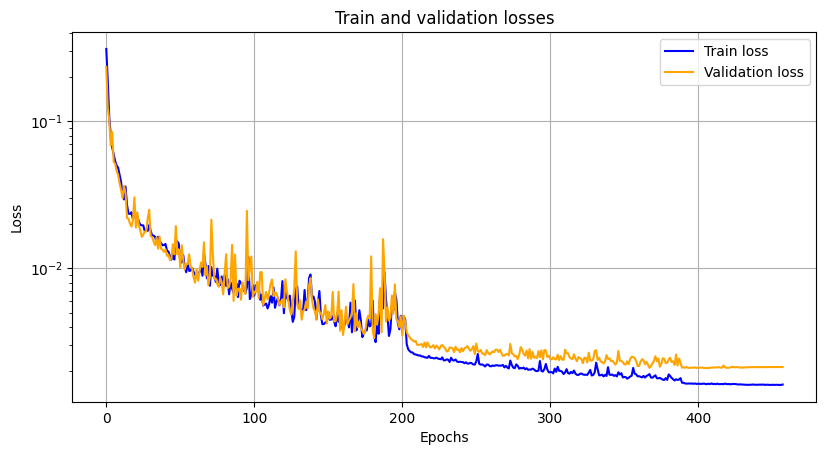

In [10]:
model.plot_training()

## Test on testing set

Now, we test our model on the training set, computing for each graph the relative errors.

In [11]:
model.test(test)


Testing graph neural network:
Graph   1 with 201 nodes, test loss is 8.38e-04, relative error is 6.23e-02
Graph   2 with 146 nodes, test loss is 2.37e-03, relative error is 6.42e-02
Graph   3 with 216 nodes, test loss is 1.35e-03, relative error is 4.78e-02
Graph   4 with 141 nodes, test loss is 4.78e-04, relative error is 3.22e-02
Graph   5 with 121 nodes, test loss is 2.70e-03, relative error is 5.52e-02
Graph   6 with 141 nodes, test loss is 1.51e-03, relative error is 4.37e-02
Graph   7 with 186 nodes, test loss is 8.58e-04, relative error is 3.73e-02
Graph   8 with 171 nodes, test loss is 1.09e-03, relative error is 4.78e-02
Graph   9 with 186 nodes, test loss is 6.97e-04, relative error is 4.43e-02
Graph  10 with 206 nodes, test loss is 4.83e-03, relative error is 7.70e-02
Graph  11 with 221 nodes, test loss is 1.10e-03, relative error is 6.06e-02
Graph  12 with 141 nodes, test loss is 2.88e-03, relative error is 6.11e-02
Graph  13 with 221 nodes, test loss is 1.90e-03, relative

## Visual comparison

We compare the plot of the solution given by FEM and by GNN. Consider the following graph, where the boundary vertices are in green.


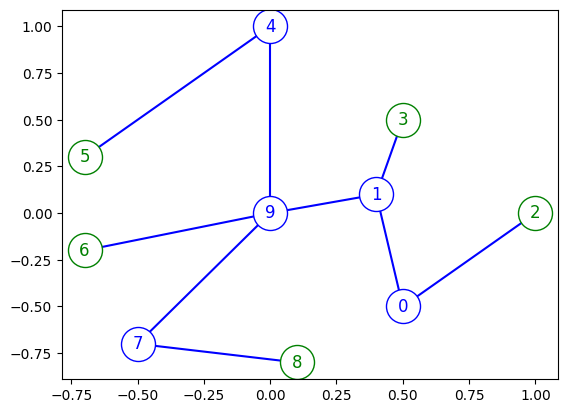

In [12]:
v = [[0.5, -0.5], [0.4, 0.1], [1, 0], [0.5, 0.5], [0, 1], [-0.7, 0.3], [-0.7, -0.2], [-0.5, -0.7], [0.1, -0.8], [0, 0]]
e = [[0, 1], [1, 0], [0, 2], [2, 0], [1, 3], [3, 1], [1, 9], [9, 1], [4, 9],
     [9, 4], [4, 5], [5, 4], [6, 9], [9, 6], [7, 9], [9, 7], [7, 8], [8, 7]]
g = Graph2D(vertexes=v, edges=e)
g.plot(plot_boundary=True)

The FEM solution is

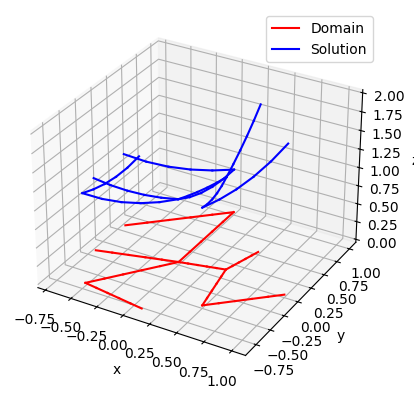

In [13]:
pde = Problem(g)
mesh_vert = pde.mesh.get_vertexes()
mesh_edges = pde.mesh.get_edges()
pde.solve()
pde.plot_solution()

While, the GNN solution is

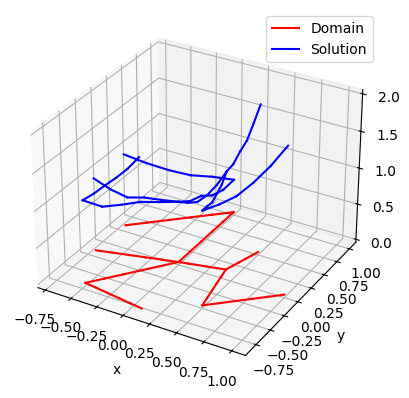

In [14]:
gnn_sol = compute_gnn_solution(mesh_vert, pde.mesh.get_full_edges(), g.get_boundary_mask(), model)
plot_solution_2d(mesh_vert, mesh_edges, gnn_sol)

We can compute the relative error as follows

In [15]:
fem_sol = pde.get_solution()
rel_errs = abs(gnn_sol - fem_sol) / fem_sol
print(f"Mean relative error between the 2 solutions is {np.mean(rel_errs):.2e}")

Mean relative error between the 2 solutions is 5.06e-02


## More testing


We try increasing the graph size to stress our network and see the behaviour. Moreover, we compare the time needed solving the PDE with FEM and with our network. Computation time to build the mesh is also included.


In [16]:
nodes = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, 2000, 5000, 10000, 20000]
fem_times, mesh_times, gnn_times = [], [], []
gnn_errs = []
for n_vertexes in nodes:
    print(f"\nGraph with {n_vertexes} physical vertices and {n_vertexes + (n_vertexes-1)*4} mesh nodes")
    # Generate graph and signal
    init_time = time.time()
    g = Graph2D.get_default_graph(n_vertexes)
    print(f"Graph built in {(time.time() - init_time):.2e} seconds")
    # Pde with fem
    init_time = time.time()
    pde = Problem(g)
    mesh_times.append(time.time() - init_time)
    print(f"Mesh built in {mesh_times[-1]:.2e} seconds")
    if n_vertexes <= 2000:
        init_time = time.time()
        pde.solve()
        fem_times.append(time.time() - init_time)
        print(f"Solving PDE with FEM, time elapsed is {fem_times[-1]:.2e} seconds")
    else:
        fem_times.append(np.inf)
    # Pde with gnn
    init_time = time.time()
    gnn_out = compute_gnn_solution(pde.mesh.get_vertexes(), pde.mesh.get_full_edges(), g.get_boundary_mask(), model)
    gnn_times.append(time.time() - init_time)
    print(f"Solving PDE with GNN, time elapsed is {gnn_times[-1]:.2e} seconds")

    # Computing error
    if n_vertexes <= 2000:
        fem_out = pde.get_solution()
        rel_errs = abs(gnn_out - fem_out) / fem_out
        gnn_errs.append(np.mean(rel_errs))
        print(f"Mean relative error is {gnn_errs[-1]:.2e}")


Graph with 5 physical vertices and 21 mesh nodes
Graph built in 7.65e-05 seconds
Mesh built in 8.91e-04 seconds
Solving PDE with FEM, time elapsed is 4.07e-03 seconds
Solving PDE with GNN, time elapsed is 1.61e-02 seconds
Mean relative error is 2.60e-02

Graph with 10 physical vertices and 46 mesh nodes
Graph built in 1.04e-04 seconds
Mesh built in 1.53e-03 seconds
Solving PDE with FEM, time elapsed is 4.45e-03 seconds
Solving PDE with GNN, time elapsed is 1.81e-02 seconds
Mean relative error is 4.89e-02

Graph with 20 physical vertices and 96 mesh nodes
Graph built in 1.14e-04 seconds
Mesh built in 1.61e-03 seconds
Solving PDE with FEM, time elapsed is 6.37e-03 seconds
Solving PDE with GNN, time elapsed is 1.62e-02 seconds
Mean relative error is 4.09e-02

Graph with 50 physical vertices and 246 mesh nodes
Graph built in 2.35e-04 seconds
Mesh built in 3.57e-03 seconds
Solving PDE with FEM, time elapsed is 1.86e-02 seconds
Solving PDE with GNN, time elapsed is 1.96e-02 seconds
Mean rel

### Computation time comparison

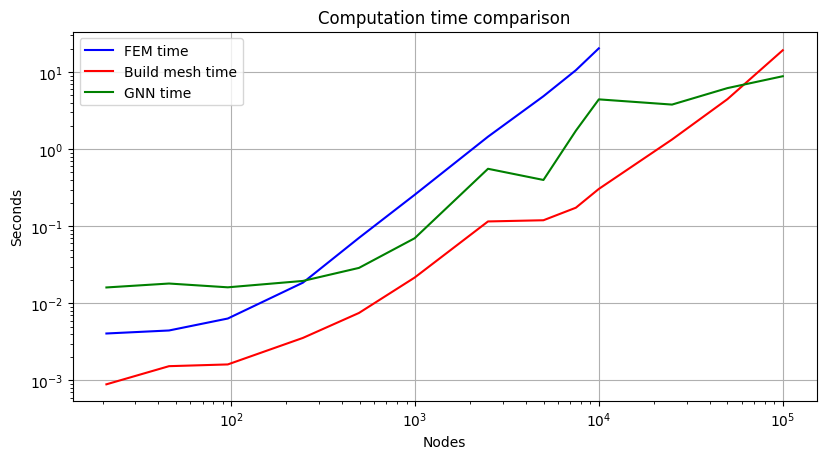

In [17]:
# Compute mesh nodes
nodes = [n + (n-1)*4 for n in nodes]
# Plot computation times
plot_testing(nodes, [fem_times, mesh_times, gnn_times],
             colors=["blue", "red", "green"],
             labels=["FEM time", "Build mesh time", "GNN time"],
             y_label="Seconds", interactive=True,
             title="Computation time comparison")

### Error plot

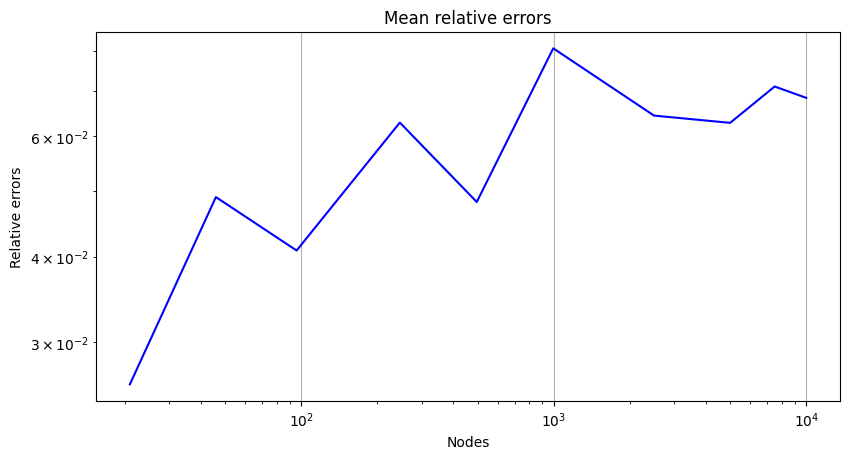

In [18]:
plot_testing(nodes[0:len(gnn_errs)], [gnn_errs],
             colors=["blue"],
             labels=[""], legend=False,
             y_label="Relative errors",
             title="Mean relative errors")